In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import h5py
import logging
from os import path
from pandas import HDFStore
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import shutil
import tempfile
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


%matplotlib inline

In [12]:
#!pip install -q git+https://github.com/tensorflow/docs

In [3]:
logdir = pathlib.Path("C:/tmp/")/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
logdir

WindowsPath('C:/tmp/tensorboard_logs')

In [5]:
#Load data from hdf5 file
root_path = "Z:/elekin"
rdo_root_path = path.join(root_path,"02-RESULTADOS/03-HANDWRITTING")
h5file = path.join(rdo_root_path, "00-OUTPUT/archimedean-")
h5filename = h5file + str(17) + ".h5"
hdf = HDFStore(h5filename)

In [6]:
#Load and scale timeseries between 0 and 1
raw_df = hdf['results/residues/rd'].T
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = pd.DataFrame(scaler.fit_transform(raw_df))
scaled_df['target'] = hdf.get('source/labels').values

In [7]:
# split data into train and test datasets (0.8, 0.2)
shuffle_df = scaled_df.sample(frac=1).reset_index(drop=True)
msk = np.random.rand(len(shuffle_df)) < 0.8
x_train = shuffle_df[msk].iloc[:,0:4096].values.astype('float32')
y_train = shuffle_df[msk]['target'].values.astype('int8')
x_test = shuffle_df[~msk].iloc[:,0:4096].values.astype('float32')
y_test = shuffle_df[~msk]['target'].values.astype('int8')

In [14]:
x_train.shape, y_train.shape

((39, 4096), (39,))

In [6]:
#Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=20)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=5)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])
        model.summary()
        history = model.fit(x_train, y_train, batch_size=None, use_multiprocessing=True, 
                            validation_data=(x_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                            verbose=0)
        return history

In [7]:
tf.random.set_seed(2019) # establecemos la semilla para tensorflow
np.random.seed(2019) # establecemos la semilla para numpy

## LSTM

Many models train better if you gradually reduce the learning rate during training. 
Use optimizers.schedules to reduce the learning rate over time:

In [8]:
STEPS_PER_EPOCH = 1
FEATURES = 4096

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [9]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[FEATURES]),
    tf.keras.layers.LSTM(8, activation=tf.nn.tanh),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [10]:
size_histories = {}

In [11]:
size_histories['ltsm/small'] = compile_and_fit(lstm, "ltsm/small", optimizer=None, max_epochs=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 4096, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


W0102 17:21:58.563409 30604 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (211.055485). Check your callbacks.



Epoch: 0, accuracy:0.5946,  binary_crossentropy:0.6915,  loss:0.6915,  val_accuracy:0.2308,  val_binary_crossentropy:0.7006,  val_loss:0.7006,  
....................................................................................................
Epoch: 100, accuracy:0.6486,  binary_crossentropy:0.6398,  loss:0.6398,  val_accuracy:0.2308,  val_binary_crossentropy:0.9098,  val_loss:0.9098,  
....................................................................................................
Epoch: 200, accuracy:0.6486,  binary_crossentropy:0.6378,  loss:0.6378,  val_accuracy:0.2308,  val_binary_crossentropy:0.8452,  val_loss:0.8452,  
.

In [15]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
bidirectional = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[FEATURES]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, activation=tf.nn.tanh)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [16]:
size_histories['ltsm/bi'] = compile_and_fit(bidirectional, "ltsm/bi", optimizer=None, max_epochs=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 4096, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                640       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


W0102 17:50:11.752647 30604 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (192.874080). Check your callbacks.



Epoch: 0, accuracy:0.6486,  binary_crossentropy:0.6719,  loss:0.6719,  val_accuracy:0.2308,  val_binary_crossentropy:0.7543,  val_loss:0.7543,  
....................................................................................................
Epoch: 100, accuracy:0.6486,  binary_crossentropy:0.6419,  loss:0.6419,  val_accuracy:0.2308,  val_binary_crossentropy:0.9320,  val_loss:0.9320,  
....................................................................................................
Epoch: 200, accuracy:0.6486,  binary_crossentropy:0.6377,  loss:0.6377,  val_accuracy:0.2308,  val_binary_crossentropy:0.8295,  val_loss:0.8295,  
.

In [ ]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
bidirectional = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[FEATURES]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation=tf.nn.tanh, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation=tf.nn.tanh)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
size_histories['ltsm/bismall'] = compile_and_fit(bidirectional, "ltsm/bismall", optimizer=None, max_epochs=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 4096, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 4096, 32)          2304      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 8,609
Trainable params: 8,609
Non-trainable params: 0
_________________________________________________________________


W0103 12:03:04.328060 30604 callbacks.py:244] Method (on_train_batch_end) is slow compared to the batch update (214.784116). Check your callbacks.



Epoch: 0, accuracy:0.3514,  binary_crossentropy:0.7021,  loss:0.7021,  val_accuracy:0.3077,  val_binary_crossentropy:0.6995,  val_loss:0.6995,  
.....................

(0.5, 1.0)

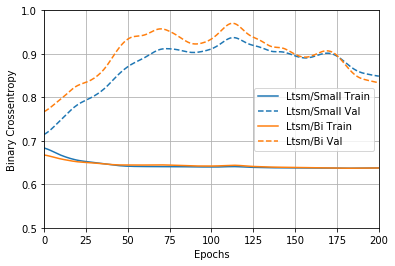

In [18]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0.5, 1.])

Text(0.5, 0, 'Epochs [Log Scale]')

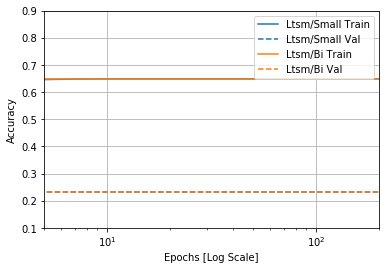

In [19]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.1, 0.9])
plt.xlabel("Epochs [Log Scale]")